In [3]:
# AIM OF THIS NOTE BOOK

## optional - download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## generate random lines

## overlay lines to images

## train yolo with images with line

In [4]:
import traceback
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import binary_dilation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from extract_centerline import extract_centerline
from scipy.interpolate import UnivariateSpline
def smooth_line(x,y,num=None,**kwargs):
    if num is None:
        num = len(x)
    w = np.arange(0,len(x),1)
    sx = UnivariateSpline(w,x,**kwargs)
    sy = UnivariateSpline(w,y,**kwargs)
    wnew = np.linspace(0,len(x),num)
    return sx(wnew),sy(wnew)

In [6]:
def make_line(nx=256,ny=256,minlen=50):
    sz = (nx,ny)
    canvas = np.zeros(sz)

    peak_num = np.random.randint(0,10,1)[0]
    for n in range(peak_num):
        x = np.random.choice(np.linspace(0, nx-1, nx),1).astype(np.int)[0]
        y = np.random.choice(np.linspace(0, ny-1, ny),1).astype(np.int)[0]
        canvas[x,y]=1

    distance = ndi.distance_transform_edt(np.logical_not(canvas))
    terrain = ndi.morphology.distance_transform_edt(distance)
    terrain = -1*terrain + -1*np.min(-1*terrain)


    prct = np.random.randint(25,75,1)[0]
    th = np.percentile(terrain.ravel(),prct)
    mask = terrain<th
    mask = np.expand_dims(mask,axis=-1)
    
    count0=0
    while True:
        pt = []
        for n in range(2):
            count1=0
            breakok = False
            while True:
                x = np.random.choice(np.linspace(0, nx-1, nx),1).astype(np.int)[0]
                y = np.random.choice(np.linspace(0, ny-1, ny),1).astype(np.int)[0]
                z = 0
                # determine first point
                if len(pt)==0 and mask[x,y,z] == 1:
                    breakok = True
                # determine second point
                if len(pt)==1 and mask[x,y,z] == 1 and \
                    np.abs(x-pt[0][0]) > minlen and np.abs(y-pt[0][1]) > minlen:
                    breakok = True
                if breakok:
                    break
                count1+=1
                if count1>100:
                    raise LookupError('ok1')
            pt.append((x,y,z))
        start_point = pt[0]
        end_point = pt[1]
        line = extract_centerline(mask,start_point,end_point)
        linexorg,lineyorg,linez=line
        smothing_factor=np.random.rand()*1000
        try:
            linex,liney = smooth_line(linexorg,lineyorg,num=100*len(linexorg),s=smothing_factor)
        except:
            pass
        if len(linexorg) > 5:
            break
            
        count0+=1
        if count0>200:
            raise LookupError('ok0')
            
    mask = mask.squeeze()
    return mask, terrain, linexorg,lineyorg, linex, liney


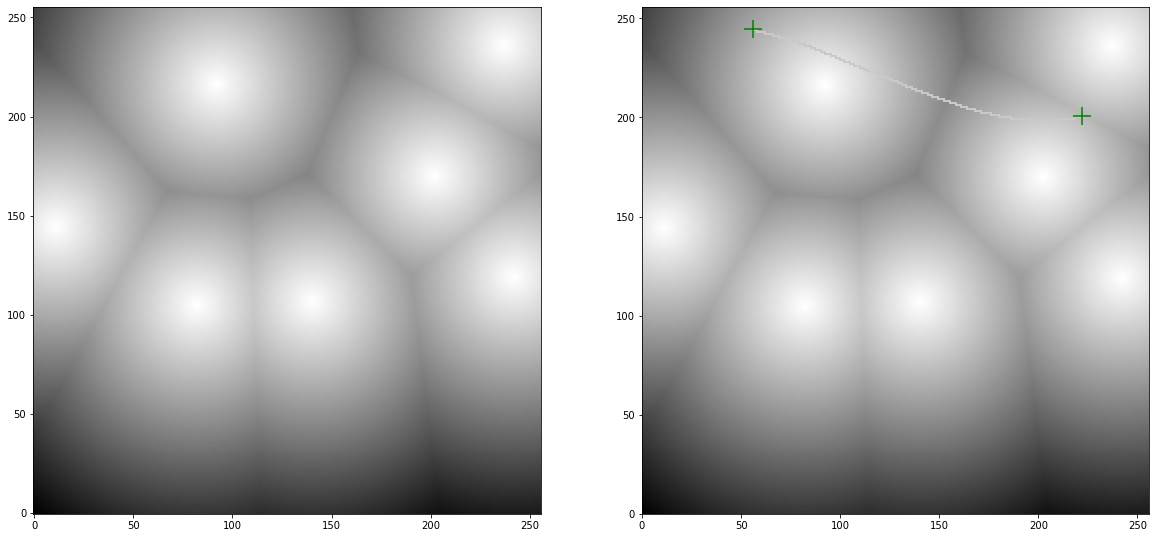

In [7]:
# create dataset with multiple lines

def make_one_sample(isplot=False,fignum=0,nx=256,ny=256,baseimage=None,minlen=50):
    if baseimage is None:
        maskorg, orgimage, linexorg,lineyorg, linex, liney = make_line(nx=nx,ny=ny,minlen=minlen)
        myimage = np.copy(orgimage)
    else:
        orgimage = np.copy(baseimage)
        myimage = np.copy(baseimage)
        
    mymax = np.max(myimage)
    linmax = np.random.randint(1,5,1)[0]
    container = []
    for x in range(linmax):
        prct = np.random.randint(75,100,1)[0]
        mymax = np.percentile(orgimage.ravel(),prct)
        _, _, linexorg,lineyorg, linex, liney = make_line(nx=nx,ny=ny,minlen=minlen)
        mask = np.zeros(myimage.shape)
        for x,y in zip(linex,liney):
            try:
                myimage[x.astype(int),y.astype(int)]=mymax
                mask[x.astype(int),y.astype(int)]=1
            except:
                pass
        endpoints = [[linex[0], liney[0]],[linex[-1], liney[-1]]]
        container.append({
            'mask':mask,
            'endpoints':endpoints,
        })
    if isplot:
        fig = plt.figure(fignum,figsize=(20,20))
        plt.subplot(121)
        plt.imshow(orgimage,cmap='gray',origin='lower')
        plt.subplot(122)
        for item in container:
            plt.scatter(item['endpoints'][0][1],item['endpoints'][0][0],300,'green',marker='+')
            plt.scatter(item['endpoints'][1][1],item['endpoints'][1][0],300,'green',marker='+',)
        plt.imshow(myimage,cmap='gray',origin='lower')
        plt.xlim(0,nx)
        plt.ylim(0,ny)
        
    return myimage, container

terrain, container = make_one_sample(isplot=True)

In [8]:
import SimpleITK as sitk
from PIL import Image
from skimage.transform import rescale
import yaml

def imread(fpath):
    reader= sitk.ImageFileReader()
    reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()    
    return arr,spacing,origin,direction

with open('/media/external/Downloads/data/luna16.yml','r') as f:
    luna16 = yaml.load(f.read())

def get_xray(isplot=False,fignum=0):
    
    filepath = np.random.choice(luna16)
    img,spacing,origin,direction = imread(filepath)
    xray = np.sum(img,axis=1)
    xray = (255.0 * (xray - xray.min())/(xray.max()-xray.min()))

    new_width = 256
    new_height = 256
    xray = rescale(xray,
                (spacing[2],spacing[0]),
                 anti_aliasing=True)
    xray = xray.astype(np.uint8)
    xray = Image.fromarray(xray,mode="L")
    xray = xray.resize((new_width, new_height), Image.ANTIALIAS)
    xray = np.array(xray)
    xray, container = make_one_sample(isplot=isplot,fignum=fignum,nx=256,ny=256,baseimage=xray)
    return xray, container

    #im = Image.fromarray(xray,mode="L")
    #im = im.resize((new_width, new_height), Image.ANTIALIAS)
    #im.save('testXray.png',"PNG")


/home/yoyoteng/anaconda3/envs/py35tf/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


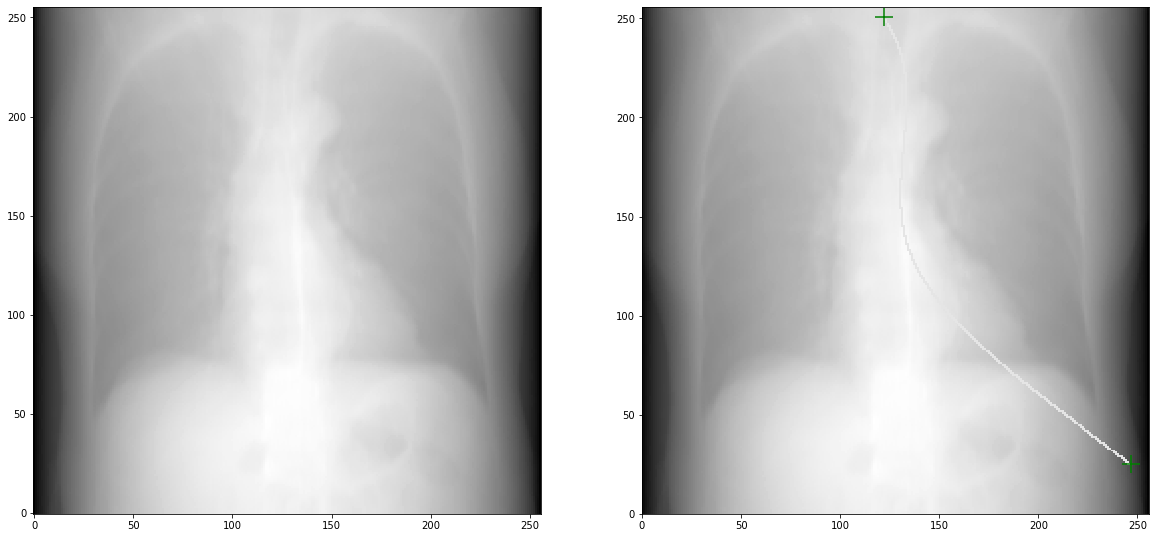

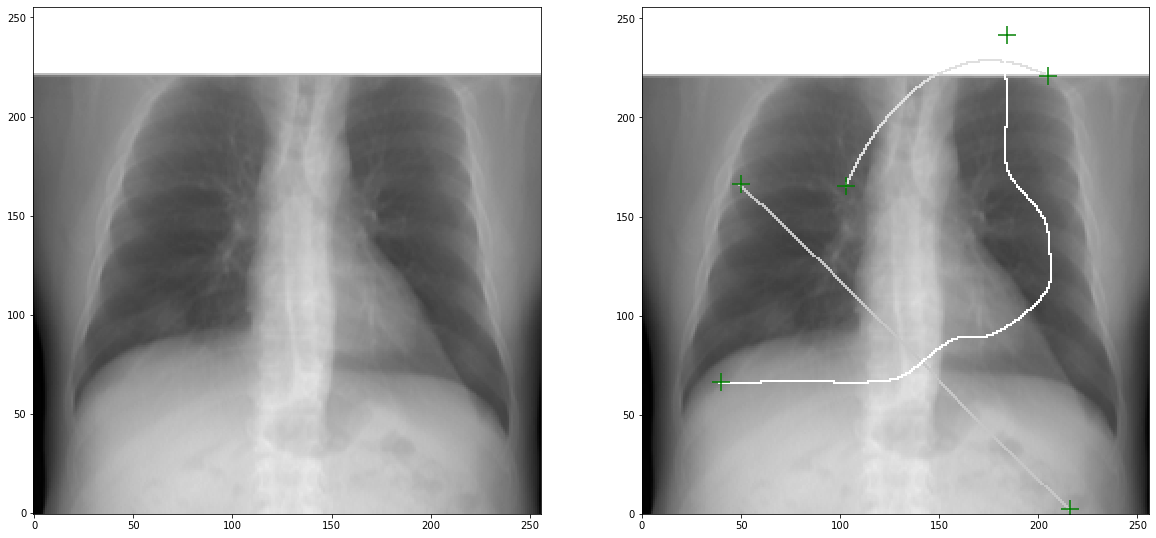

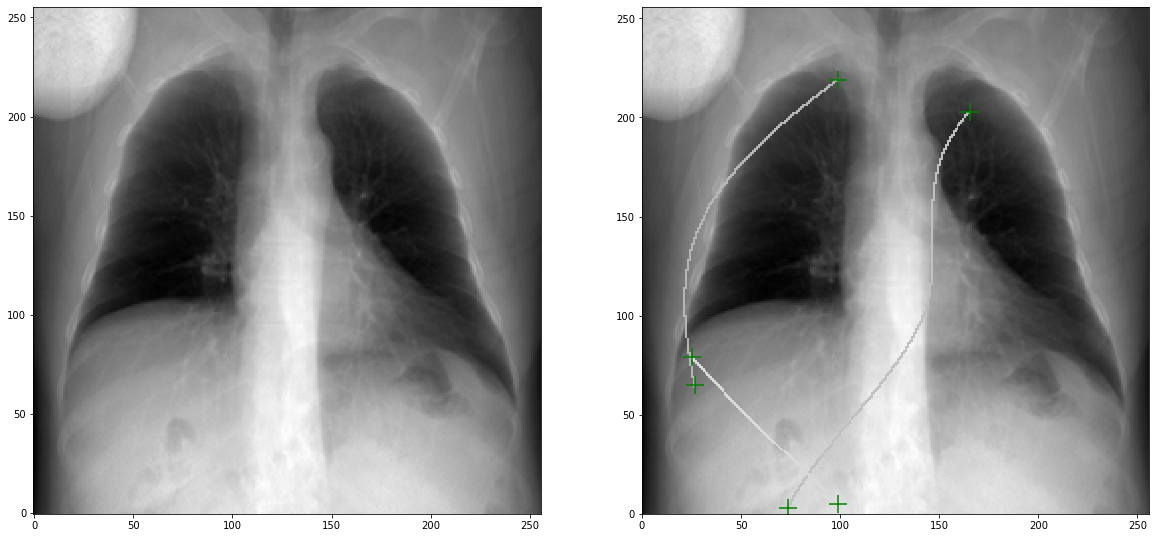

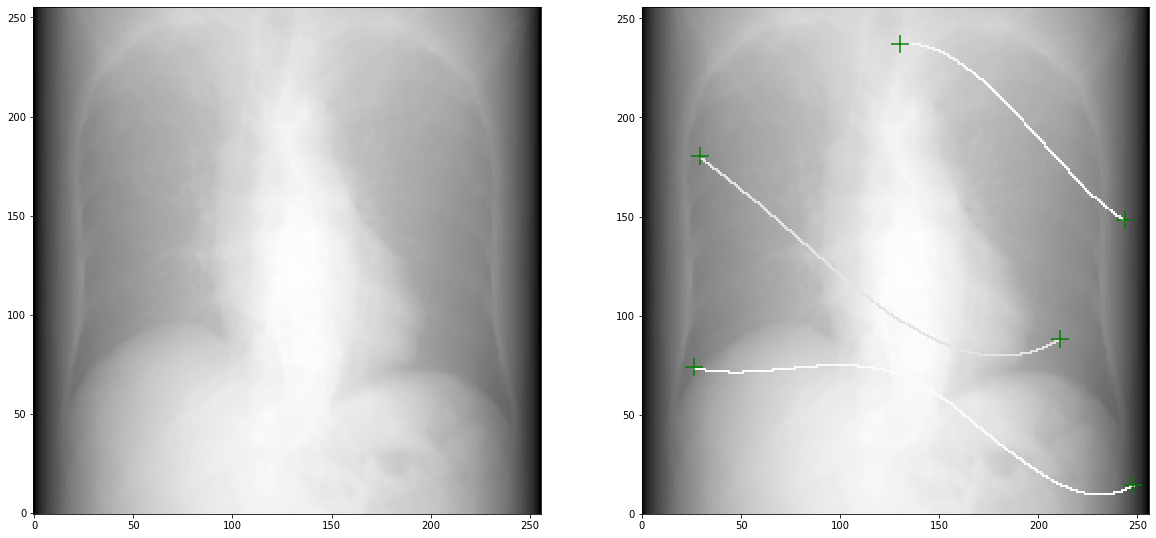

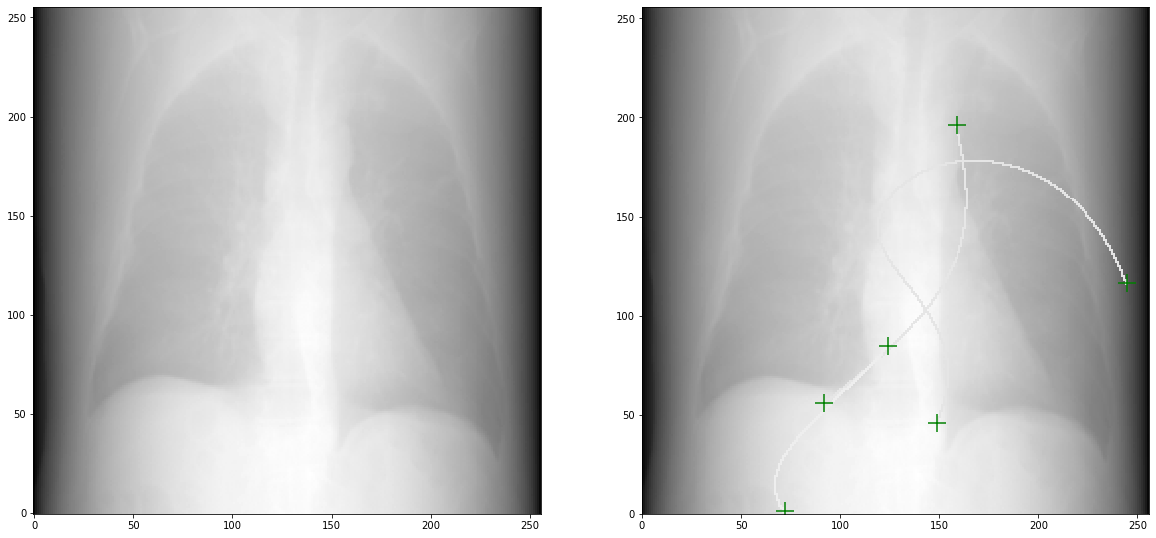

In [9]:
for n in range(5):
    try:
        xray, container = get_xray(isplot=True,fignum=n)
    except:
        pass
        traceback.print_exc()


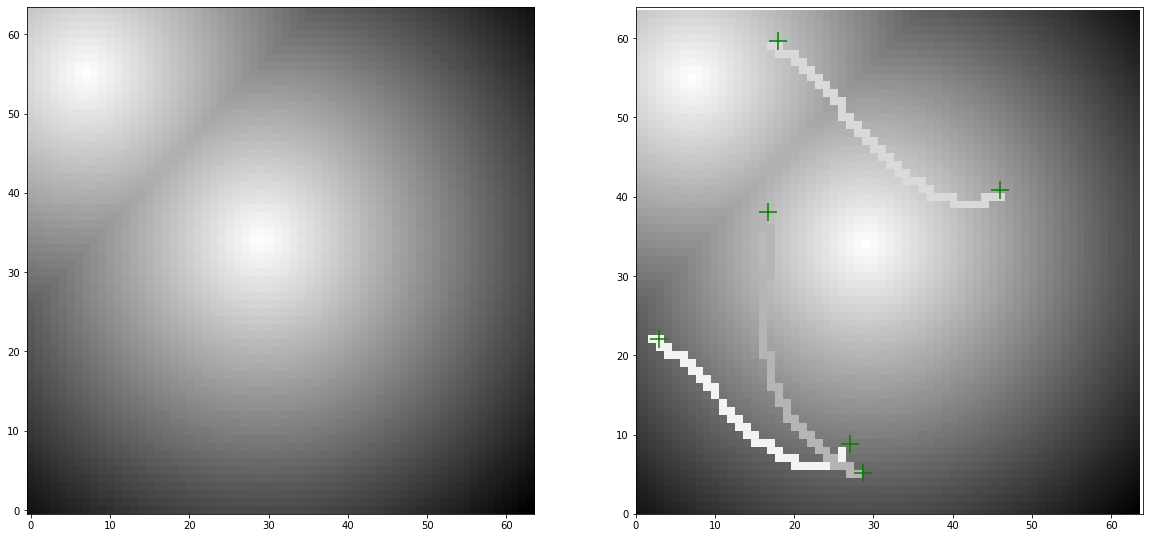

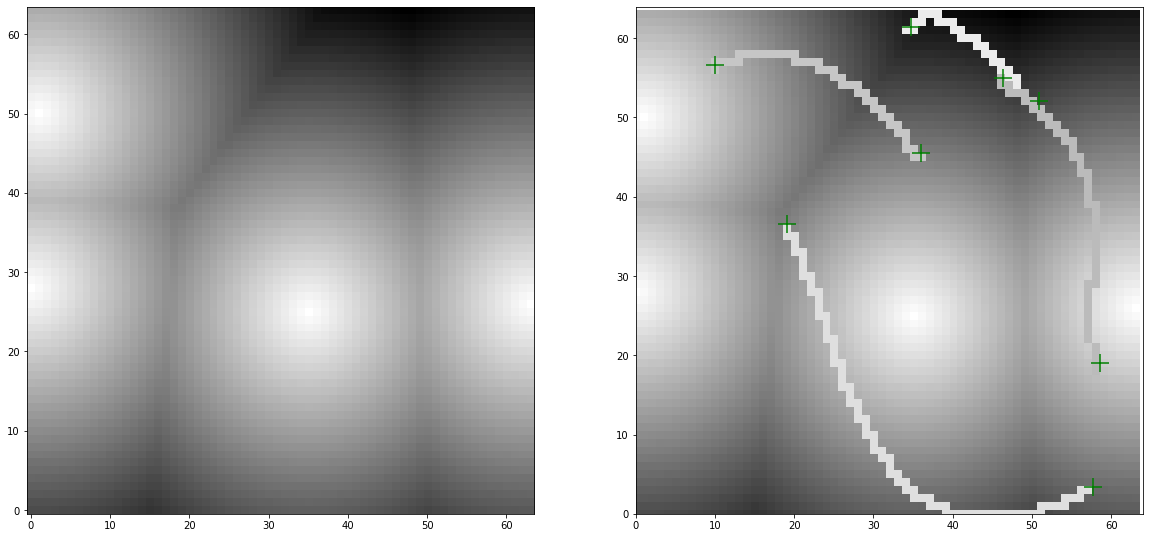

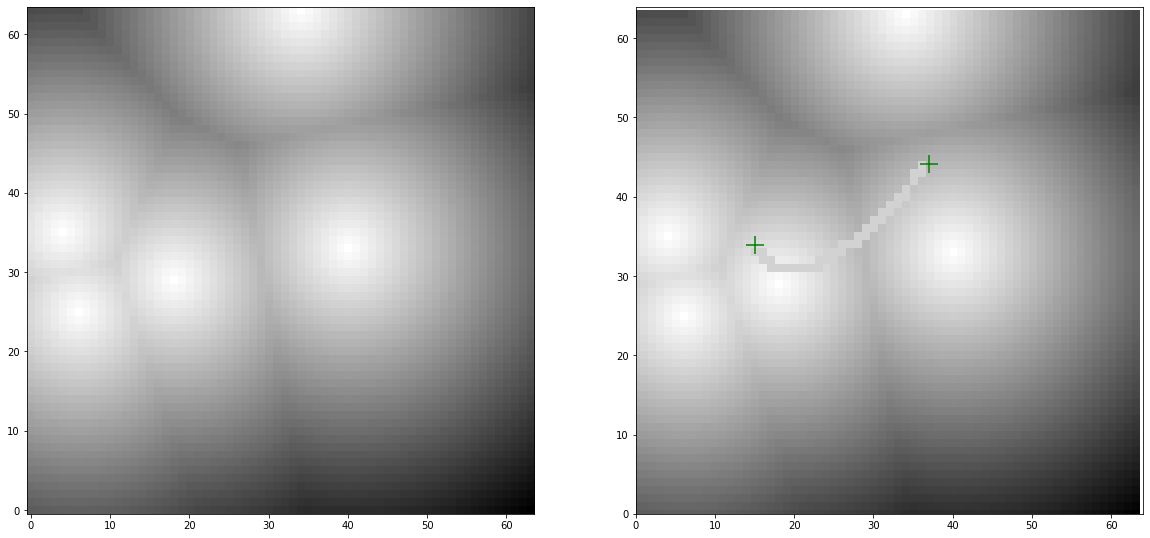

In [10]:
for n in range(3):
    try:
        terrain, container = make_one_sample(nx=64,ny=64,minlen=10,
            isplot=True,fignum=n,)
    except:
        pass
        traceback.print_exc()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


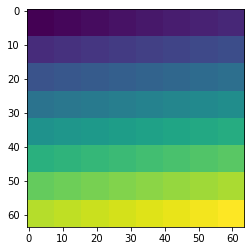

In [11]:
szx,szy,szz=64,64,64
smx,smy=8,8
grid = np.zeros((szx,szy)).astype(np.uint)

anchor_dict={}
for x in range(szx):
    for y in range(szy):
        px = x//smx
        py = y//smy
        code = py + smx*px
        if code not in anchor_dict.keys():
            anchor_dict[code]=(x,y)
        grid[x,y]=code
        
plt.imshow(grid)
print(np.unique(grid))

In [23]:
# x  (None,64,64)
# y0 (None,64,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None,64,64,64) - 64x(64,64) mask

In [50]:
def make_data(N=5):
    X0 = np.zeros((N,szx,szy)).astype(np.uint8)
    Y0 = np.zeros((N,szz,5)).astype(np.uint8)
    Y1 = np.zeros((N,szx,szy,szz)).astype(np.uint8)

    c=0
    for n in range(N*100):
        try:
            # make random line
            terrain, container = make_one_sample(nx=64,ny=64,minlen=10)
            # rescale input image
            terrain = (255*(terrain-np.max(terrain))/(np.max(terrain)-np.min(terrain))).astype(np.uint8)
            # for each line
            for row in container:
                # get mask and end points
                mask=row['mask'].astype(np.uint8)
                endpoints = np.array(row['endpoints']).astype(np.int)
                x0,y0=endpoints[0,:]
                x1,y1=endpoints[1,:]
                # ensure end points in line
                #assert(mask[x0,y0]==1 and mask[x1,y1]==1)

                istube=1
                # find min max point
                mask_indices = np.argwhere(mask>0)

                minx=np.min(mask_indices[:,0])
                miny=np.min(mask_indices[:,1])

                maxx=np.max(mask_indices[:,0])
                maxy=np.max(mask_indices[:,1])

                medx=np.median(mask_indices[:,0]).astype(np.int)
                medy=np.median(mask_indices[:,1]).astype(np.int)

                ind = grid[minx,miny]
                # get anchor in grid
                anchorx,anchory=anchor_dict[ind]
                # get rel start
                relstartx = minx-anchorx
                relstarty = miny-anchory
                # rel x
                relendx = maxx-minx
                relendy = maxy-miny
                # assign ys
                yolo = np.array([istube,relstartx,relstarty,relendx,relendy])
                #print(Y0[c,ind,:].shape,yolo.shape)
                
                Y0[c,ind,:]=yolo
                Y1[c,ind,:,:]=mask
            
            X0[c,:,:]=terrain
        
        except:
            if c >= N:
                break
            X0[c,:,:]=0
            Y0[c,:,:]=0
            Y1[c,:,:,:]=0
        
        if c>=N:
            break
        
        c+=1
        
    return X0,Y0,Y1


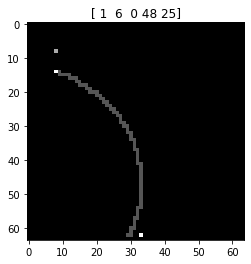

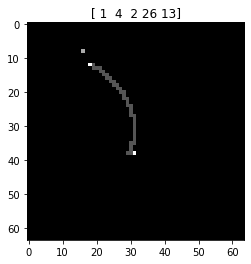

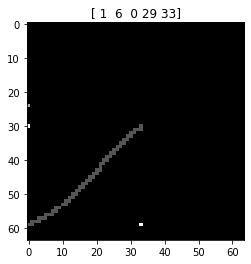

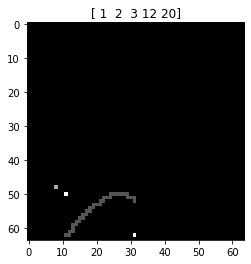

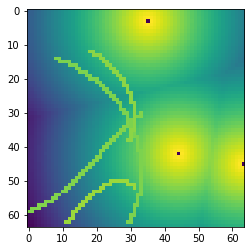

In [51]:
X0,Y0,Y1 = make_data(N=5)
c=0
ind = 0
for aind in range(smx*smy):    
    y0 = Y0[ind,aind,:]
    istube,relsx,relsy,relex,reley = y0
    if istube == 0:
        continue
    
    tmp = Y1[ind,aind,:,:]
    
    ax,ay = anchor_dict[aind]
    
    startx = ax+relsx
    starty = ay+relsy
    
    endx = startx+relex
    endy = starty+reley
    
    tmp[ax,ay]=2
    tmp[startx,starty]=3
    tmp[endx,endy]=3

    plt.figure(c)    
    plt.title('{}'.format(y0))
    plt.imshow(tmp,cmap='gray',origin='upper')    
    c+=1
    
plt.figure(c)
plt.imshow(X0[ind,])

In [52]:
X0,Y0,Y1 = make_data(N=500)

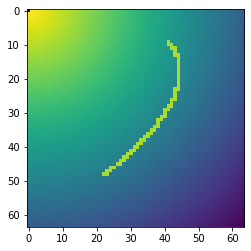

In [62]:
plt.imshow(X0[-9,:])

In [53]:
# simple yolo

In [ ]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import LearningRateScheduler

lambda_pos = 10.0

def yolo_loss(y_true, y_pred):
    loss_cat = tf.squared_difference(y_true[:,0], y_pred[:,0])
    loss_x = tf.squared_difference(y_true[:,1], y_pred[:,1])
    loss_y = tf.squared_difference(y_true[:,2], y_pred[:,2])
    loss_pos = tf.multiply(tf.multiply(lambda_pos, y_true[:,0]), tf.add(loss_x, loss_y))
    loss = tf.add(loss_cat,loss_pos)
    return tf.reduce_mean(loss)
      
model = Sequential()

model.add(Conv2D(16, 3, input_shape=(256,256,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss=yolo_loss, optimizer=opt.rmsprop(lr=0.001))
history = model.fit(x_train, y_train,
                    batch_size=16, epochs=50,
                    verbose=1, validation_data=(x_test, y_test))